In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm

from load_data import BiopsyDataset, DATA_DIR, TRANSFORMS, P53_CLASS_NAMES, BagDataset
from resnet import ResNetModel, ResNetModelDoubleBinary
from resnet_nm import ResNetModelNM

CLAM_DIR = os.path.join('..','CLAM')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))

Device: cuda
Device: cuda
Device: cuda


In [2]:
img_size = 64
grid_spacing = 256

test_transform = TRANSFORMS["normalize"]
imagenet_transform = TRANSFORMS["imgnet_normalize"]

In [3]:
# Load the pytorch lightning model ResNetModelNM from the file models/acc0.88_epoch07_s64_nm.ckpt
model_nm = ResNetModelNM.load_from_checkpoint("models/acc0.90_epoch03_s64_nm.ckpt")

MODEL: ResNetModel (nullmutation)
MODEL ARGS: lr=0.001, weight_decay=0.0005, lr_step_size=30, lr_gamma=0.1


In [13]:
from RetCCL.custom_objects import retccl_resnet50, HistoRetCCLResnet50_Weights

retccl = retccl_resnet50(weights=HistoRetCCLResnet50_Weights.RetCCLWeights).to(device)
# retccl is pretrained on images with size 256x256 at 1 micron per pixel
num_ftrs = retccl.fc.in_features
print("Number of features: {}".format(num_ftrs))
retccl.fc = nn.Identity()

Number of features: 2048


In [14]:
TRANSFORM = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                      std=[0.229, 0.224, 0.225]) # What this does is it subtracts the mean from each channel and divides by the std
])

In [15]:
from clam_model.model_clam import CLAM_SB

def initiate_model(ckpt_path):    
    model = CLAM_SB(dropout=True,
                    n_classes=3,
                    encoding_size=2048)

    ckpt = torch.load(ckpt_path)
    ckpt_clean = {}
    for key in ckpt.keys():
        if 'instance_loss_fn' in key:
            continue
        ckpt_clean.update({key.replace('.module', ''):ckpt[key]})
    model.load_state_dict(ckpt_clean, strict=True)

    model.relocate()
    model.eval()
    return model

model_clam = initiate_model(os.path.join(CLAM_DIR, 'results', 'test_s1', 's_0_checkpoint.pt'))

In [16]:
# Get img paths
size = 64
grid_spacing = 256

root_dir = DATA_DIR
quantile_range_threshold = 0.10
labels_filename = "test"

# Read the labels
labels_file = os.path.join(root_dir, f"{labels_filename}.csv")
labels = np.loadtxt(labels_file, delimiter=",", skiprows=1)
labels = labels.astype(int)

wildtype_indices = np.where(labels == 0)[0]
overexpression_indices = np.where(labels == 1)[0]
nullmutation_indices = np.where(labels == 2)[0]
doubleclone_indices = np.where(labels == 3)[0]

torch.Size([112, 1, 64, 64])


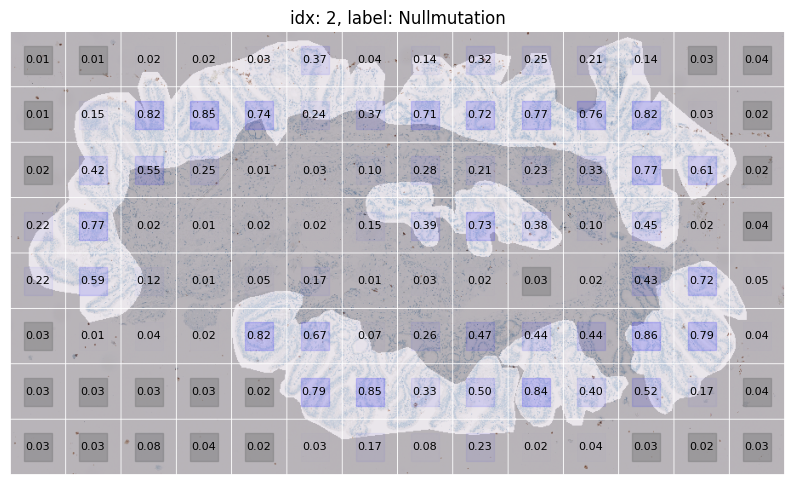

torch.Size([1, 3]) torch.Size([1, 1]) torch.Size([1, 112])


{}

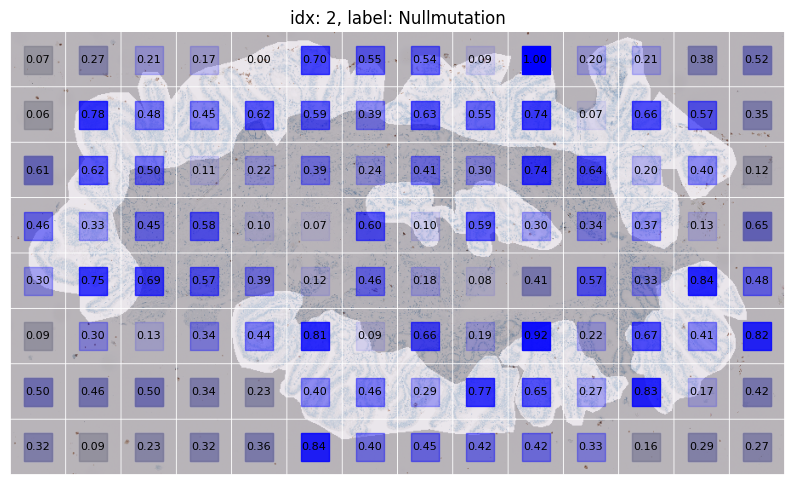

In [20]:
# idx, label = labels[nullmutation_indices[2]]
idx, label = labels[32]

resize_factor = size / grid_spacing

# Read the image and turn into patches
img_file = os.path.join(root_dir, "biopsies", f"{idx}.png")
mask_file = os.path.join(root_dir, "masks", f"{idx}.png")

img = plt.imread(img_file)
img = torch.tensor(img).permute(2, 0, 1).float() # (3, h, w)

# Resize the img so that the height and width are multiples of grid_spacing, 
# rounded to the nearest multiple.
# This prevents the last row and column of patches from being cut off.
# We also resize the image by the resize_factor instead of each patch separately
new_size = (round(img.shape[1]*resize_factor/size)*size, 
            round(img.shape[2]*resize_factor/size)*size)
img = torch.nn.functional.interpolate(img.unsqueeze(0), size=new_size, 
    mode='bilinear', align_corners=False)[0]

patches = torch.nn.functional.unfold(img.unsqueeze(0), 
    kernel_size=(size, size), 
    stride=(size, size)) # (1, 3*size*size, n_patches)
patches = patches.permute(0, 2, 1).reshape(-1, 3, size, size) # (n_patches, 3, size, size)

# Remove patches with low difference between the 75th and 1st percentile
qranges = torch.quantile(patches.view(patches.shape[0], -1), 0.75, dim=-1) - \
            torch.quantile(patches.view(patches.shape[0], -1), 0.01, dim=-1)
non_empty_idx = torch.where(qranges >= quantile_range_threshold)[0]

if len(patches) == 0:
    print(f"Empty bag: {idx}")
    exit()

patch_indices = []
if label in [0,1]: # If wildtype, all patches are wildtype
    mask_patches = torch.zeros_like(patches)[:,0:1,:,:]
elif label in [2,3]:
    mask = plt.imread(mask_file)
    mask = torch.tensor(mask).float() # (h, w)
    mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0), 
        size=new_size, mode='nearest')[0][0]
    mask_patches = torch.nn.functional.unfold(mask.unsqueeze(0), 
        kernel_size=(size, size), 
        stride=(size, size)) # (size*size, n_patches)
    mask_patches = mask_patches.permute(1, 0).reshape(-1, 1, size, size) # (n_patches, 1, size, size)



# Predict nullmutation using the model
with torch.no_grad():
    inputs = patches.to(device)
    # inputs = patches[non_empty_idx].to(device)

    # Predict the patchwise nm probability
    patch_preds = model_nm(inputs) # (n_patches, 1)


    # Predict the patchwise probability using the CLAM model
    # Do the transforms on the patches
    inputs = torch.stack([TRANSFORM(patch) for patch in patches]).to(device)
    # First process the patches into latents with the retccl model
    latents = retccl(inputs) # (n_patches, num_ftrs)
    # Then process the latents with the CLAM model
    logits, Y_prob, Y_hat, A_raw, results_dict = model_clam(latents) # tuple of logits, Y_prob, Y_hat, A_raw, results_dict


# Visualize the patches in a grid
n_rows = new_size[0] // size
n_cols = new_size[1] // size

patch_grid = torchvision.utils.make_grid(patches, nrow=n_cols, padding=1, pad_value=1)
# Make mask_patches have three channels
print(mask_patches.shape)
mask_patches = torch.cat([mask_patches]*3, dim=1)
mask_grid = torchvision.utils.make_grid(mask_patches, nrow=n_cols, padding=1, pad_value=1)

plt.figure(figsize=(10, 10))
plt.imshow(patch_grid.permute(1, 2, 0))
plt.axis('off')
plt.imshow(mask_grid.permute(1, 2, 0), alpha=0.2)

# Put the patch predictions on the patches
patch_preds = patch_preds.cpu().numpy().reshape(-1)
for i, pred in enumerate(patch_preds):
    row = i // n_cols
    col = i % n_cols
    s = size + 1
    m = size // 4
    x = col*s + s//2
    y = row*s + s//2
    # Draw a square in the middle of the patch with its opacity proportional to the prediction
    plt.fill([col*s+m, col*s+s-m, col*s+s-m, col*s+m], 
             [row*s+m, row*s+m, row*s+s-m, row*s+s-m], color='blue', alpha=pred/5)

    plt.text(x, y, "{:.2f}".format(pred), color='black', fontsize=8, ha='center', va='center')

    # If i not in non_empty_idx, draw a grey square in the middle of the patch
    if i not in non_empty_idx:
        plt.fill([col*s+m, col*s+s-m, col*s+s-m, col*s+m], 
                 [row*s+m, row*s+m, row*s+s-m, row*s+s-m], color='grey', alpha=0.5)

plt.title(f"idx: {idx}, label: {P53_CLASS_NAMES[label]}")
plt.show()


# Visualize the CLAM predictions
plt.figure(figsize=(10, 10))
plt.imshow(patch_grid.permute(1, 2, 0))
plt.axis('off')
plt.imshow(mask_grid.permute(1, 2, 0), alpha=0.2)

# Put the patch predictions on the patches (Y_prob)
print(Y_prob.shape, Y_hat.shape, A_raw.shape)
display(results_dict)
# A = nn.functional.softmax(A_raw, dim=1)
# Normalize A to be between 0 and 1
A = (A_raw - A_raw.min()) / (A_raw.max() - A_raw.min())
Y_prob = A.cpu().numpy().reshape(-1)
for i, prob in enumerate(Y_prob):
    row = i // n_cols
    col = i % n_cols
    s = size + 1
    m = size // 4
    x = col*s + s//2
    y = row*s + s//2
    # Draw a square in the middle of the patch with its opacity proportional to the prediction
    plt.fill([col*s+m, col*s+s-m, col*s+s-m, col*s+m], 
             [row*s+m, row*s+m, row*s+s-m, row*s+s-m], color='blue', alpha=prob)

    plt.text(x, y, "{:.2f}".format(prob), color='black', fontsize=8, ha='center', va='center')

    # If i not in non_empty_idx, draw a grey square in the middle of the patch
    if i not in non_empty_idx:
        plt.fill([col*s+m, col*s+s-m, col*s+s-m, col*s+m], 
                 [row*s+m, row*s+m, row*s+s-m, row*s+s-m], color='grey', alpha=0.5)
        
plt.title(f"idx: {idx}, label: {P53_CLASS_NAMES[label]}")
plt.show()

# Using nullmutation model to classify

In [5]:
from clam_model.use_clam import process_image
import cv2

In [10]:
# Test the patch model
model_nm.outputs['test'] = []
model_nm = model_nm.to(device)
for i, row in tqdm(enumerate(labels), total=len(labels)):
    idx = row[0]
    label = torch.tensor(row[1]).to(device).unsqueeze(0)
    img = plt.imread(os.path.join(DATA_DIR, "biopsies", f"{idx}.png")) # shape (h, w, 3)
    resize_factor = 0.25
    img = cv2.resize(img, (0,0), fx=resize_factor, fy=resize_factor)
    patches, indices = process_image(torch.tensor(img).permute(2,0,1), patch_size=64, transform=torch.nn.Identity())
    # Predict the patchwise nm probability
    with torch.no_grad():
        patch_scores = model_nm(patches.to(device)) # (n_patches, 1)
    presence_prob = patch_scores.max().item()
    pred = (presence_prob > 0.5)*2

    model_nm.outputs['test'].append({"preds": pred, "labels": label.item(), "presence_probs": presence_prob, "patch_scores": patch_scores})

    # Clear the cache
    torch.cuda.empty_cache()
print("Accuracy: ", np.mean([1 if o['preds'] == o['labels'] else 0 for o in model_nm.outputs['test']]))

100%|██████████| 60/60 [00:29<00:00,  2.04it/s]

Accuracy:  0.25


Accuracy:  0.25


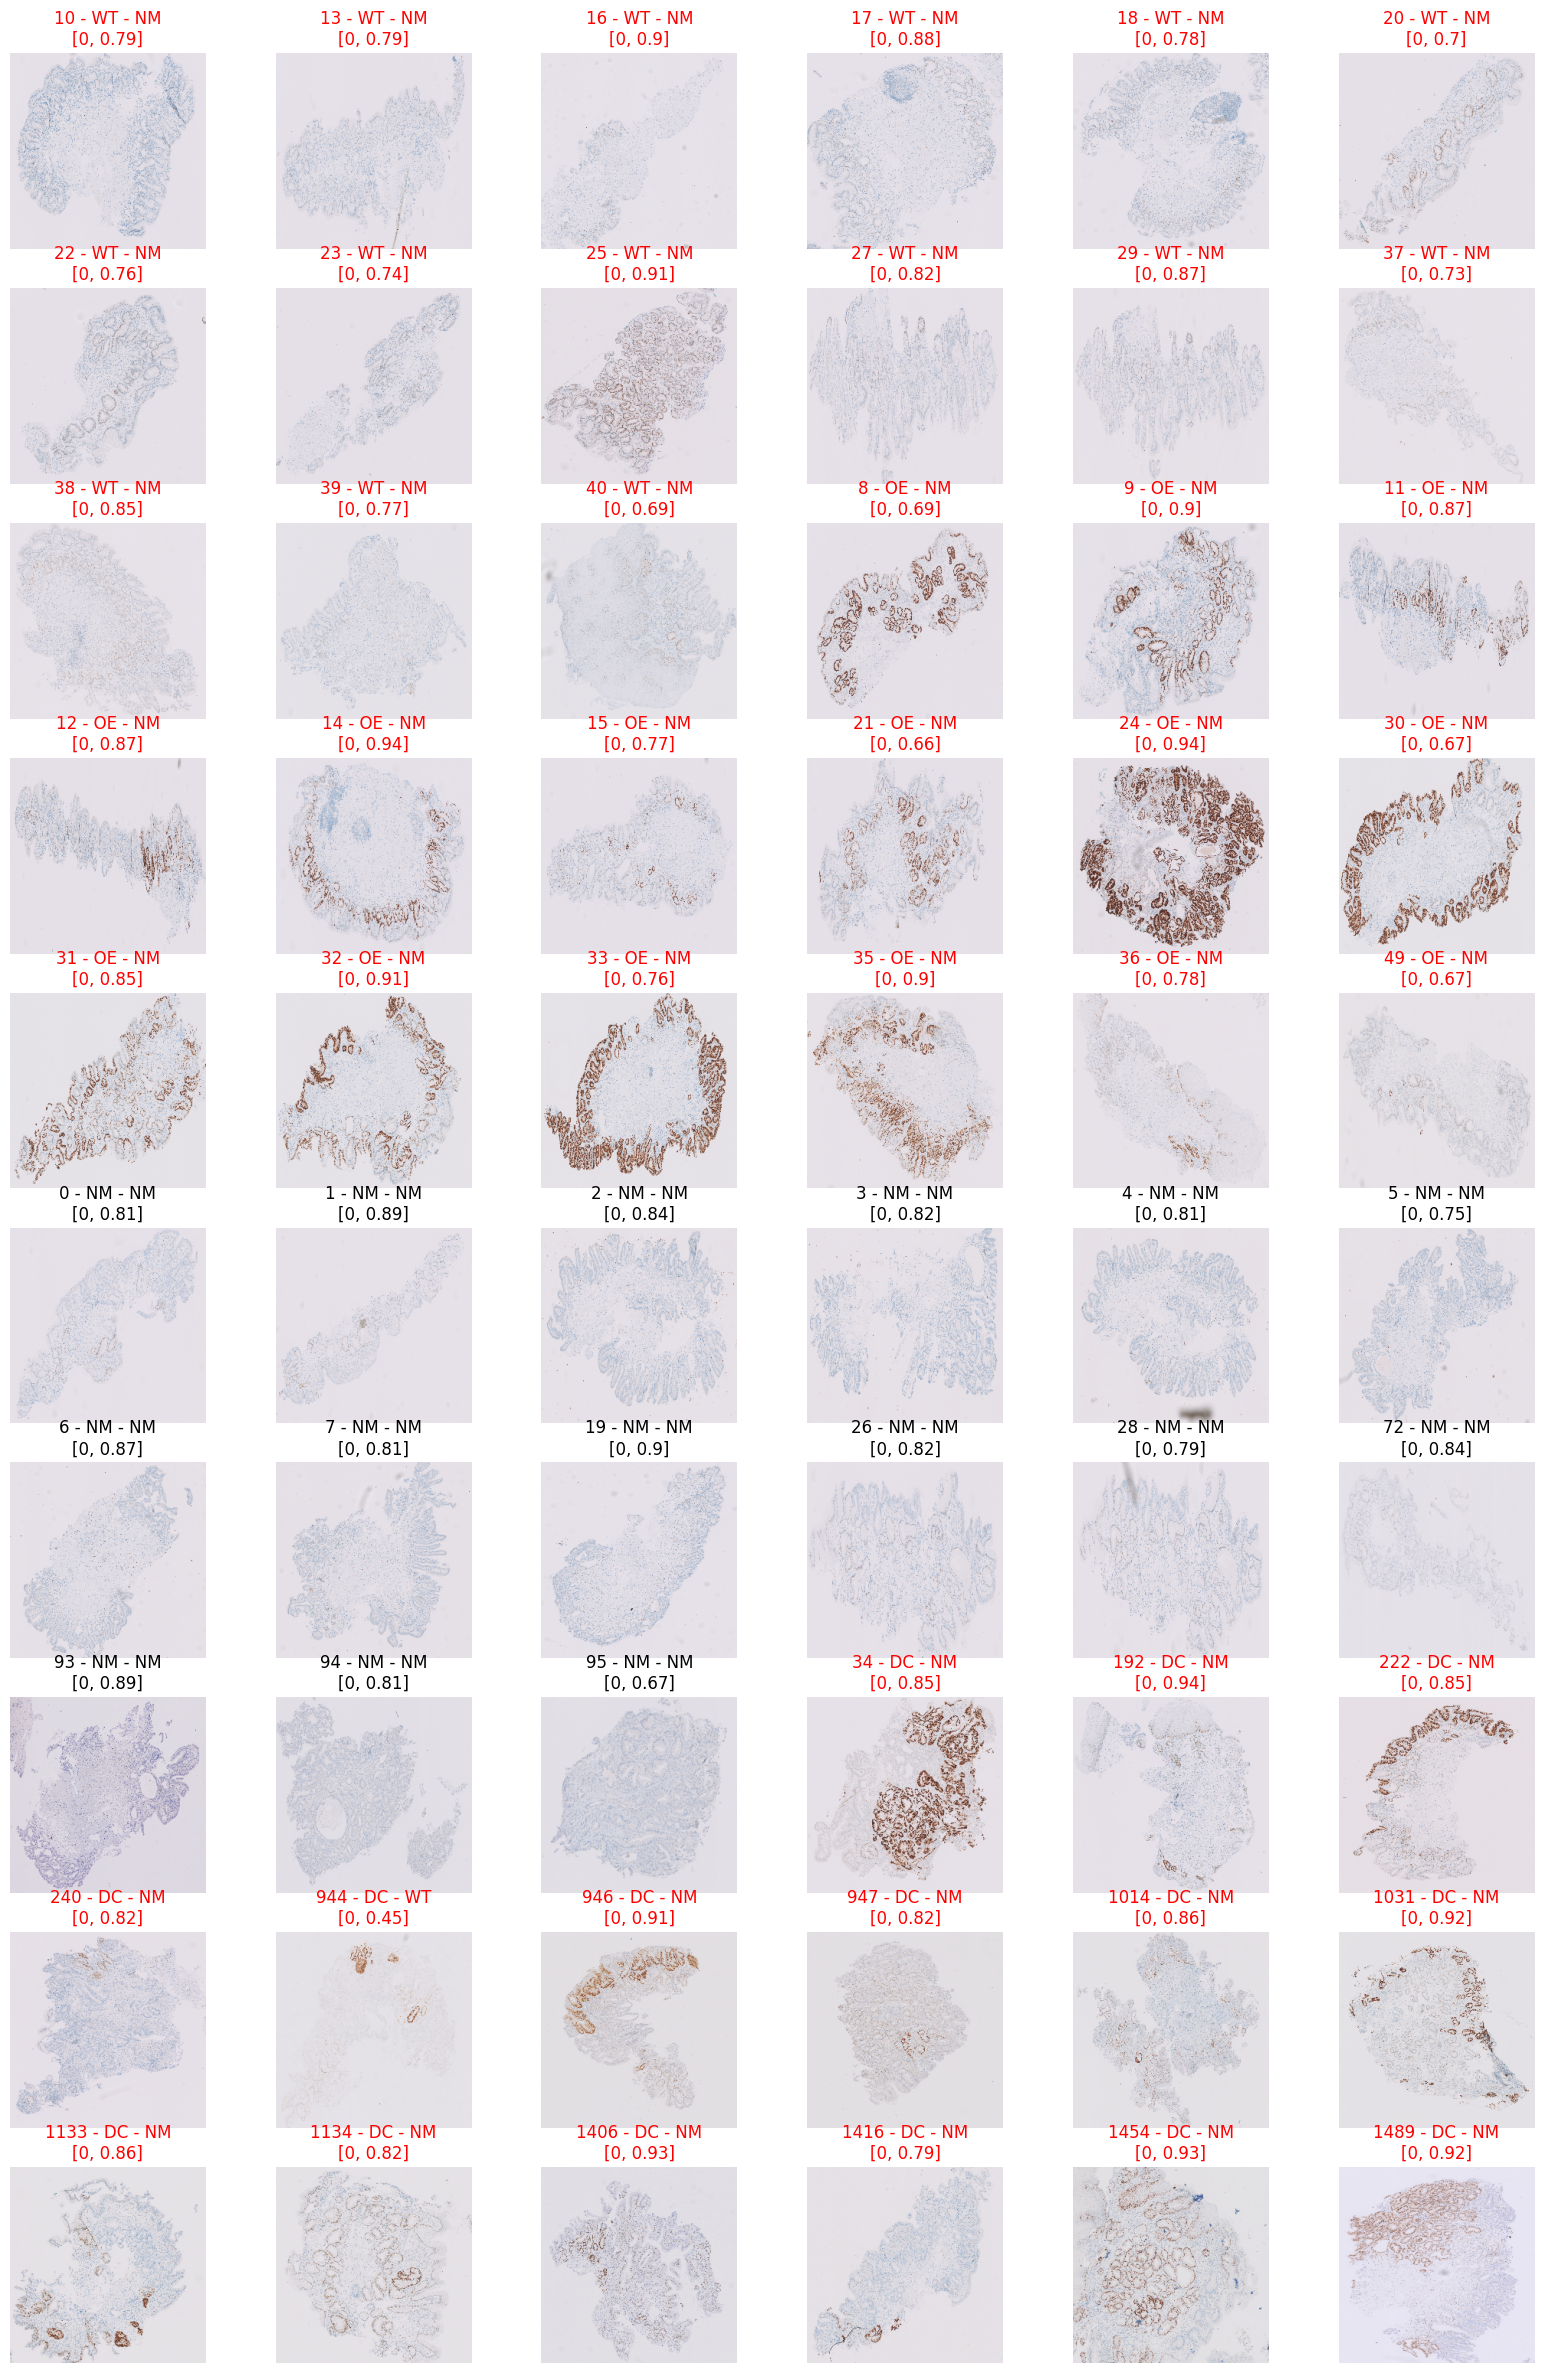

In [11]:
# Plot 10x6 grid of test images
label_mapping = {0:"WT", 1:"OE", 2:"NM", 3:"DC"}
fig, axs = plt.subplots(10, 6, figsize=(20, 30))
mdl = model_nm
preds = []
labelss = []
for i in range(len(labels)):
    biop_idx = labels[i][0]
    img = plt.imread(os.path.join(DATA_DIR, "biopsies", f"{biop_idx}.png"))
    # Resize img to 256x256
    img = cv2.resize(img, (256, 256))
    label = labels[i][1]
    row = i // 6
    col = i % 6
    axs[row, col].imshow(img)
    # class_probs = [round(e,2) for e in mdl.outputs['test'][i]['presence_probs'].tolist()]
    # pred = mdl.outputs['test'][i]['preds']
    # class_probs = mdl.outputs['test'][i]['patch_scores'].max(dim=0)[0].tolist()

    # sorted_oe_patch_scores = sorted(mdl.outputs['test'][i]['patch_scores'][:,0].tolist(), reverse=True)
    sorted_nm_patch_scores = sorted(mdl.outputs['test'][i]['patch_scores'].tolist(), reverse=True)
    class_probs = [0, np.mean(sorted_nm_patch_scores[:1])]

    pred = 1*(class_probs[0] > 0.5) + 2*(class_probs[1] > 0.5)
    label = mdl.outputs['test'][i]['labels']
    preds.append(pred)
    labelss.append(label)
    title = f"{biop_idx} - {label_mapping[label]} - {label_mapping[pred]}\n{[round(e,2) for e in class_probs]}"
    axs[row, col].set_title(title)
    axs[row, col].axis("off")

    # Make title red if the prediction is wrong
    if pred != label:
        axs[row, col].set_title(title, color="red")

print("Accuracy: ", np.mean([1 if p == l else 0 for p, l in zip(preds, labelss)]))
plt.show()